# **MLPP23 // Assignment #6**

assigned : **Apr 26, 2023**

DUE : **May 8, 2023 11:59pm**

## NYC Stop and Frisk: predictors of outcomes

<img src="https://i1.wp.com/www.nationalreview.com/wp-content/uploads/2018/01/new-york-city-stop-and-frisk-crime-decline-conservatives-wrong-1.jpg?fit=789%2C460&ssl=1" width=500x>

---

NYC's *Stop, Question, and Frisk* is a program/practice by the New York Police Department in which officers approach, temporarily detain, and (in some cases) frisk civilians on the street for weapons or contraband.  The program's implementation has been highly controversial with accusations of racial profiling and bias, and in 2013 a US federal judge found that the program had been carried out in a way that violated the US Constitution.  Using publicly available Stop and Frisk [data](https://www1.nyc.gov/site/nypd/stats/reports-analysis/stopfrisk.page), in this assignment you will expore the ability of Random Forest models to predict whether, for those stops in which a suspect was suspected of having a weapon, a weapon is likely to have been found (an analysis related to the one carried out in [Goel, Rao, & Shroff, 2016](https://projecteuclid.org/journals/annals-of-applied-statistics/volume-10/issue-1/Precinct-or-prejudice-Understanding-racial-disparities-in-New-York-Citys/10.1214/15-AOAS897.full)).

<u>**Instructions for tasks that will be graded are in bold below.**</u>

---

**Please list the names of the other students with whom you worked for this assignment (if none, put "None").**

Had a quick discussion with Farhad regarding the variables taken.

---

### **Part 1 - Loading and Cleaning data**

**Read in the 2010 stop and frisk data from  `mlpp23/data/stop_and_frisk/` into a DataFrame called `sqf` setting `low_memory=False` in `pd.read_csv`.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# -- useful imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
import graphviz

In [ ]:
fname='/content/drive/MyDrive/mlpp23/data/stop_and_frisk/2010.csv'
sqf= pd.read_csv(fname,low_memory=False )

**Looking at the "Data Dictionary" in the link above (i.e., the SQF file documentation found** [here](https://www1.nyc.gov/assets/nypd/downloads/zip/analysis_and_planning/stop-question-frisk/SQF-File-Documentation.zip)**) drop all columns except:**

<b>

1. the period of observation
2. whether the stop was made inside or outside
3. columns that indicate that a weapon was found on the subject
4. columns related to whether the subject was suspected of carrying a weapon
5. the subject's sex
6. the subject's age
7. the subject's race

</b>

In [ ]:
sqf.head()

,year,pct,ser_num,datestop,timestop,recstat,inout,trhsloc,perobs,crimsusp,...,zip,addrpct,sector,beat,post,xcoord,ycoord,dettypcm,linecm,detailcm
0,2010,78,81,1012010,340,1,O,P,1,MISD,...,,78,,,,995504,189189,CM,1,20
1,2010,26,21,1042010,1548,1,O,P,2,ROBBERY,...,,26,F,,,998641,236979,CM,1,85
2,2010,18,34,1092010,1550,1,I,T,1,MISD,...,,18,H,,,,,CM,1,20
3,2010,108,102,1112010,1120,A,O,P,5,BURGLARY,...,,108,G,,,1009146,209683,CM,1,14
4,2010,23,2437,1222010,1620,1,O,H,1,CPM,...,,23,,,,,,CM,1,27


In [ ]:
cols=["perobs","inout","sex","age","race","pistol","riflshot","asltweap","knifcuti","machgun","othrweap","cs_objcs","rf_othsw","rf_bulg","cs_bulge","sb_outln","sb_hdobj"]

In [ ]:
sqf=sqf[cols]

In [ ]:
sqf.head()

,perobs,inout,sex,age,race,pistol,riflshot,asltweap,knifcuti,machgun,othrweap,cs_objcs,rf_othsw,rf_bulg,cs_bulge,sb_outln,sb_hdobj
0,1,O,M,17,B,N,N,N,N,N,N,N,N,N,N,N,N
1,2,O,M,20,P,N,N,N,N,N,N,N,N,N,N,N,N
2,1,I,M,55,Q,N,N,N,N,N,N,N,Y,N,N,N,Y
3,5,O,M,17,Q,N,N,N,N,N,N,N,N,N,N,N,N
4,1,O,M,55,B,N,N,N,N,N,N,N,N,N,N,N,N


**Convert all binary columns (i.e., columns with categories that only have two possible values) to 1s and 0s.**

In [ ]:
mapping = {'N': 0, 'Y': 1}
cols=["pistol","riflshot","asltweap","knifcuti","machgun","othrweap","cs_objcs","rf_othsw","rf_bulg","cs_bulge","sb_outln","sb_hdobj"]
sqf[cols] = sqf[cols].replace(mapping)
sqf.head()

,perobs,inout,sex,age,race,pistol,riflshot,asltweap,knifcuti,machgun,othrweap,cs_objcs,rf_othsw,rf_bulg,cs_bulge,sb_outln,sb_hdobj
0,1,O,M,17,B,0,0,0,0,0,0,0,0,0,0,0,0
1,2,O,M,20,P,0,0,0,0,0,0,0,0,0,0,0,0
2,1,I,M,55,Q,0,0,0,0,0,0,0,1,0,0,0,1
3,5,O,M,17,Q,0,0,0,0,0,0,0,0,0,0,0,0
4,1,O,M,55,B,0,0,0,0,0,0,0,0,0,0,0,0


**Only keep rows that indicate that a suspect might have been suspected of carrying a weapon.**

In [ ]:
cols=["cs_objcs","rf_othsw","rf_bulg","cs_bulge","sb_outln","sb_hdobj"]
ind=(sqf[cols] >0).any(axis=1)
sqf=sqf[ind]

**Create a column `"weapon_fnd"` to indicate whether a weapon (of any type) was found or not (1 or 0).**

In [ ]:
cols=["pistol","riflshot","asltweap","knifcuti","machgun","othrweap"]
sqf["weapon_fnd"]=(sqf[cols] >0).any(axis=1).astype(int)

**How many times was a weapon found on the suspect?  How many times was a weapon not found on the suspect?**

In [ ]:
sqf["weapon_fnd"].value_counts()

0    109125
1      5874
Name: weapon_fnd, dtype: int64

A weapon was found on the subject 5874 times. It was not found on the subject 109125 times.

**In the next part, `"weapon_fnd"` will be your target variable, and note from your answer above that the data set is not balanced.  Create a balanced data set.**

In [ ]:
# Creating a balanced dataset
sqf_0= sqf[sqf["weapon_fnd"]==0]
sqf_1= sqf[sqf["weapon_fnd"]==1]

In [ ]:
sqf_0_sub=sqf_0.sample(len(sqf_1), random_state=9731)

In [ ]:
len(sqf_0_sub)

5874

In [ ]:
sqf_bal=pd.concat((sqf_0_sub, sqf_1))

In [ ]:
sqf_bal["weapon_fnd"].value_counts()

0    5874
1    5874
Name: weapon_fnd, dtype: int64

In [ ]:
sqf_bal["race"].value_counts()

B    5852
Q    3070
W    1372
P     848
Z     255
A     254
U      74
I      23
Name: race, dtype: int64

### **Part 3 - Fitting Tree-based Classifier Models**

The goal of this part of the assignment is to build a model that uses several features of the stops in which the subject was suspected of carrying a weapon to predict whether a weapon was actually found.

**Create your features from your balanced data set using the period of observation, whether the stop was inside or outside, the sex of the subject, the age of the subject, and the race of the subject as features (make sure to One Hot Encode categorical features).  Set the `"weapon_fnd"` column to be your target.**

In [ ]:
cols=["perobs","inout","sex","age","race"]
feat=sqf_bal[cols]
feat.head()

,perobs,inout,sex,age,race
298980,5,O,M,25,I
8577,3,O,M,23,Q
594595,2,O,M,22,Q
460642,1,O,M,22,B
253025,2,O,M,26,P


In [ ]:
feat=pd.get_dummies(feat) #one-hot encoding
feat.head()

,perobs,age,inout_I,inout_O,sex_F,sex_M,sex_Z,race_A,race_B,race_I,race_P,race_Q,race_U,race_W,race_Z
298980,5,25,0,1,0,1,0,0,0,1,0,0,0,0,0
8577,3,23,0,1,0,1,0,0,0,0,0,1,0,0,0
594595,2,22,0,1,0,1,0,0,0,0,0,1,0,0,0
460642,1,22,0,1,0,1,0,0,1,0,0,0,0,0,0
253025,2,26,0,1,0,1,0,0,0,0,1,0,0,0,0


In [ ]:
targ=sqf_bal["weapon_fnd"]

**Split your features and target into a training and testing set using an 80/20 split, setting `random_state` to `302`.**

In [ ]:
feat_tr, feat_te, targ_tr, targ_te = train_test_split(feat, targ, test_size=0.2, random_state=302)

**Fit a `RandomForestClassifier` to your data with default hyperparameters and comment on its accuracy.**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfc=RandomForestClassifier()
rfc.fit(feat_tr,targ_tr)

RandomForestClassifier()

In [ ]:
pred_tr = rfc.predict(feat_tr)
acc_tr = accuracy_score(targ_tr, pred_tr)
print("training accuracy = {0:.3f}".format(acc_tr))

training accuracy = 0.692


In [ ]:
pred_te = rfc.predict(feat_te)
acc_te = accuracy_score(targ_te, pred_te)
print("testing accuracy = {0:.3f}".format(acc_te)) #Ideally we should not be fitting the model with testing data before hyperparameter tuning but to compared the accuracy of both
#the models I have fitted for the testing data in this cas

testing accuracy = 0.577


In [ ]:
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay

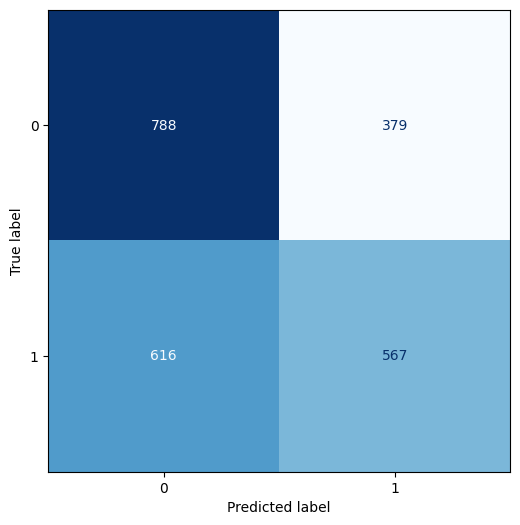

In [ ]:
fig,ax =plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay.from_estimator(rfc,feat_te,targ_te,cmap="Blues",colorbar=False,ax=ax)

In [ ]:
from sklearn.metrics import precision_score , recall_score , classification_report

In [ ]:
# precision and recall for weapon found
prec=precision_score(targ_te, pred_te, pos_label= 1)
recall=recall_score(targ_te, pred_te, pos_label=1)

print("model precision : {0:.2f}".format(prec))
print("model recall : {0:.2f}".format(recall))

model precision : 0.60
model recall : 0.48


In [ ]:
print(classification_report(targ_te,pred_te))

              precision    recall  f1-score   support

           0       0.56      0.68      0.61      1167
           1       0.60      0.48      0.53      1183

    accuracy                           0.58      2350
   macro avg       0.58      0.58      0.57      2350
weighted avg       0.58      0.58      0.57      2350



The accuracy of the model on the training data is 69.2% and accuracy on testing data is lower. The precision and recall for weapon found is 59% and 47%. This model performs better in case of weapon not found but it's performance decreases in case of weapon found.

Ideally we should not be fitting the model with testing data before hyperparameter tuning but to compared the accuracy of both the models I have fitted for the testing data in this case.

**Tune the `min_samples_leaf` hyperparameter using Grid Search with Cross Validation and comment on the resultant model accuracy.**

In [ ]:
# -- import helper tools from sklearn
from sklearn.model_selection import GridSearchCV

In [ ]:
# -- select the parameter(s) to tune and the values to try
tuned_parameters = [{"min_samples_leaf":[1,2,5,10,20,50,100,200,500]}]

In [ ]:
# -- perform Grid Search
rfc_tune = RandomForestClassifier()
cv_tune = GridSearchCV(rfc_tune,tuned_parameters)
cv_tune.fit(feat_tr,targ_tr)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid=[{'min_samples_leaf': [1, 2, 5, 10, 20, 50, 100, 200,
                                               500]}])

In [ ]:
cv_tune.best_params_

{'min_samples_leaf': 20}

In [ ]:
rfc_mod = RandomForestClassifier(min_samples_leaf=20)

# -- fit a decision tree classifier on the TRAINING data
rfc_mod.fit(feat_tr, targ_tr)

# -- assess the accuracy on the TRAINING data
pred_tr = rfc_mod.predict(feat_tr)
acc_tr = accuracy_score(targ_tr, pred_tr)
print("training accuracy = {0:.3f}".format(acc_tr))

# -- assess the accuracy on the TESTING data
pred_te = rfc_mod.predict(feat_te)
acc_te = accuracy_score(targ_te, pred_te)
print("testing accuracy = {0:.3f}".format(acc_te))

training accuracy = 0.617
testing accuracy = 0.595


In [ ]:
# precision and recall for weapon found
prec=precision_score(targ_te, pred_te, pos_label= 1)
recall=recall_score(targ_te, pred_te, pos_label=1)

print("model precision : {0:.2f}".format(prec))
print("model recall : {0:.2f}".format(recall))

model precision : 0.64
model recall : 0.45


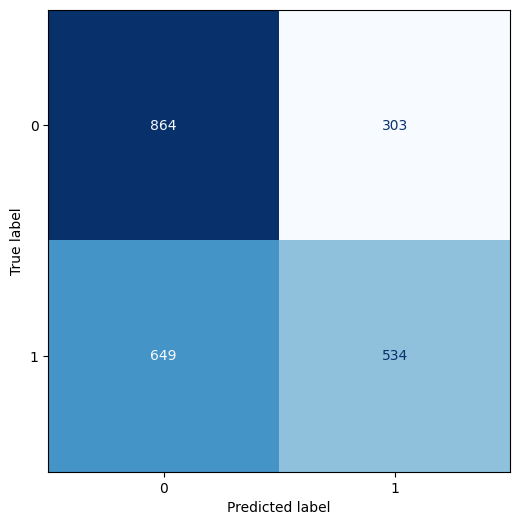

In [ ]:
fig,ax =plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay.from_estimator(rfc_mod,feat_te,targ_te,cmap="Blues",colorbar=False,ax=ax)

In this case the training accuracy is 61.9% and testing accuracy is 59.4%. They are closer to each other when compared to before. The recall is 0.45 in this case. This model performs better in case of weapon not found but it's performance decreases in case of weapon found in both cases.

### **Part 4 - Fitting Tree-based Regression Models**

In this part of the assignment, you'll be extending your modeling to include predictions of *probabilities* that a weapon was found given your features using tree-based regression models.

**Fit a Random Forest *Regressor* to the data (being sure to tune `min_samples_leaf` with Grid Search).**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# -- select the parameter(s) to tune and the values to try
tuned_parameters = [{"min_samples_leaf":[1,2,5,10,20,50,100,200,500]}]

In [ ]:
# -- perform Grid Search
rfg_tune = RandomForestRegressor()
cv_tune = GridSearchCV(rfg_tune,tuned_parameters)
cv_tune.fit(feat_tr,targ_tr)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid=[{'min_samples_leaf': [1, 2, 5, 10, 20, 50, 100, 200,
                                               500]}])

In [ ]:
cv_tune.best_params_

{'min_samples_leaf': 200}

In [ ]:
rfg_mod = RandomForestRegressor(min_samples_leaf=200)
rfg_mod.fit(feat_tr, targ_tr)
pred_tr = rfg_mod.predict(feat_tr)
pred_te = rfg_mod.predict(feat_te)

In [ ]:
feat_te["pred_reg"]= pred_te

In [ ]:
feat_te.head()

,perobs,age,inout_I,inout_O,sex_F,sex_M,sex_Z,race_A,race_B,race_I,race_P,race_Q,race_U,race_W,race_Z,pred_reg
18871,1,18,0,1,0,1,0,0,0,0,0,1,0,0,0,0.465281
493236,5,46,0,1,0,1,0,0,0,0,0,1,0,0,0,0.510282
435835,2,16,0,1,0,1,0,0,0,0,1,0,0,0,0,0.470025
111074,5,51,0,1,1,0,0,0,1,0,0,0,0,0,0,0.395015
75988,1,19,0,1,0,1,0,0,1,0,0,0,0,0,0,0.407928


In [ ]:
feat["race_B"].value_counts()

0    5896
1    5852
Name: race_B, dtype: int64

In [ ]:
feat["race_W"].value_counts()

0    10376
1     1372
Name: race_W, dtype: int64

**With this Random Forest Regressor, we can interpret the prediction of the model as the probability that a weapon would be found given the features.  Make a histogram (`range` of 0 to 1 and 30 bins) of the predictions of this model using the subset of the testing data for which the subject's race was white and another histogram using the subset of the testing data for which the subject's race was black.**

In [ ]:
sub_black=feat_te[feat_te["race_B"]==1]
sub_white=feat_te[feat_te["race_W"]==1]

In [ ]:
sub_black.head()

,perobs,age,inout_I,inout_O,sex_F,sex_M,sex_Z,race_A,race_B,race_I,race_P,race_Q,race_U,race_W,race_Z,pred_reg
111074,5,51,0,1,1,0,0,0,1,0,0,0,0,0,0,0.395015
75988,1,19,0,1,0,1,0,0,1,0,0,0,0,0,0,0.407928
494903,1,19,1,0,0,1,0,0,1,0,0,0,0,0,0,0.449020
223469,5,13,0,1,0,1,0,0,1,0,0,0,0,0,0,0.362985
599306,2,12,1,0,0,1,0,0,1,0,0,0,0,0,0,0.447075


In [ ]:
sub_white.head()

,perobs,age,inout_I,inout_O,sex_F,sex_M,sex_Z,race_A,race_B,race_I,race_P,race_Q,race_U,race_W,race_Z,pred_reg
435269,1,21,0,1,0,1,0,0,0,0,0,0,0,1,0,0.564042
277206,1,26,0,1,0,1,0,0,0,0,0,0,0,1,0,0.565826
591653,1,30,0,1,0,1,0,0,0,0,0,0,0,1,0,0.568968
300528,1,29,0,1,0,1,0,0,0,0,0,0,0,1,0,0.568457
184758,1,34,0,1,0,1,0,0,0,0,0,0,0,1,0,0.572717


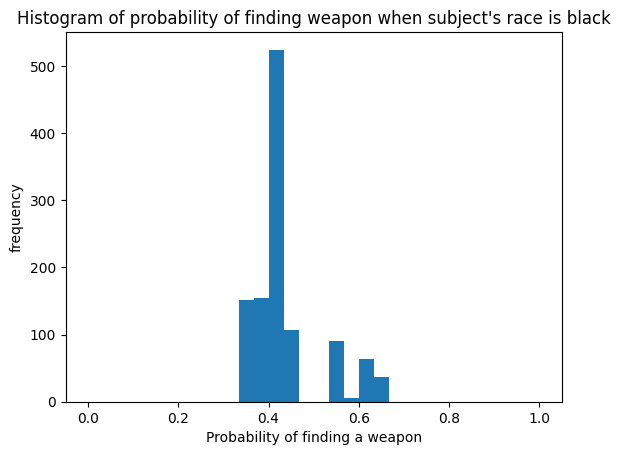

In [ ]:
plt.hist(sub_black['pred_reg'],bins=30, range=[0,1]) #plotting histogram
plt.xlabel("Probability of finding a weapon")
plt.ylabel("frequency")
plt.title("Histogram of probability of finding weapon when subject's race is black")
plt.show()

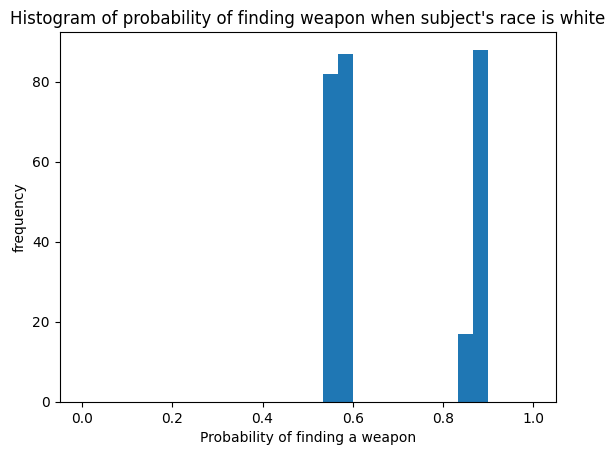

In [ ]:
plt.hist(sub_white['pred_reg'],bins=30, range=[0,1]) #plotting histogram
plt.xlabel("Probability of finding a weapon")
plt.ylabel("frequency")
plt.title("Histogram of probability of finding weapon when subject's race is white")
plt.show()

**Comment on the potential implications of this plot.**

From both the histograms we can see that subject's who race is white has more probability of weapon being found when compared to subject's whose race is black. Though from the data we can clearly see that majority of the subjects who were suspected belonged to the race black.5852 suspects were black and 1372 suspects belonged to the white race. There is a disproportion with respect to the race which was suspected and race which has more probability of weapon being found.

**Repeat the above (fit a Random Forest Regressor and plot histograms of the predictions of the subsets of the test data for which the subject was white and black) but *removing the subject's race as a feature on which the model is fit*.**

In [ ]:
feat_tr_1= feat_tr.iloc[:,:7]

In [ ]:
feat_te_1=feat_te.iloc[:,:7]

In [ ]:
feat_tr_1

,perobs,age,inout_I,inout_O,sex_F,sex_M,sex_Z
598911,1,15,0,1,0,1,0
186626,1,31,0,1,0,1,0
204188,2,30,0,1,0,1,0
409886,3,40,1,0,0,1,0
83909,2,22,0,1,0,1,0
...,...,...,...,...,...,...,...
502086,1,19,0,1,0,1,0
144463,2,20,0,1,0,1,0
24256,1,24,0,1,0,1,0
424493,5,16,0,1,0,1,0


In [ ]:
# -- select the parameter(s) to tune and the values to try
tuned_parameters = [{"min_samples_leaf":[1,2,5,10,20,50,100,200,500]}]

# -- perform Grid Search
rfg_tune_1 = RandomForestRegressor()
cv_tune_1 = GridSearchCV(rfg_tune_1,tuned_parameters)
cv_tune_1.fit(feat_tr_1,targ_tr)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid=[{'min_samples_leaf': [1, 2, 5, 10, 20, 50, 100, 200,
                                               500]}])

In [ ]:
cv_tune_1.best_params_

{'min_samples_leaf': 200}

In [ ]:
rfg_mod_1 = RandomForestRegressor(min_samples_leaf=200)
# -- fit a decision tree classifier on the TRAINING data
rfg_mod_1.fit(feat_tr_1, targ_tr)
# -- assess the accuracy on the TRAINING data
pred_tr_1 = rfg_mod_1.predict(feat_tr_1)
pred_te_1 = rfg_mod_1.predict(feat_te_1)

In [ ]:
feat_te["pred_reg_1"]= pred_te_1

In [ ]:
feat_te.head()

,perobs,age,inout_I,inout_O,sex_F,sex_M,sex_Z,race_A,race_B,race_I,race_P,race_Q,race_U,race_W,race_Z,pred_reg,pred_reg_1
18871,1,18,0,1,0,1,0,0,0,0,0,1,0,0,0,0.465281,0.454380
493236,5,46,0,1,0,1,0,0,0,0,0,1,0,0,0,0.510282,0.451504
435835,2,16,0,1,0,1,0,0,0,0,1,0,0,0,0,0.470025,0.415082
111074,5,51,0,1,1,0,0,0,1,0,0,0,0,0,0,0.395015,0.421007
75988,1,19,0,1,0,1,0,0,1,0,0,0,0,0,0,0.407928,0.442174


In [ ]:
sub_black=feat_te[feat_te["race_B"]==1]
sub_white=feat_te[feat_te["race_W"]==1]

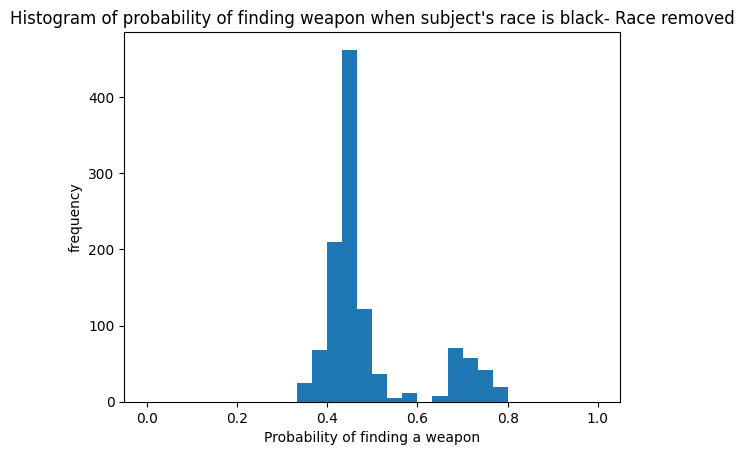

In [ ]:
plt.hist(sub_black['pred_reg_1'],bins=30, range=[0,1],) #plotting histogram
plt.xlabel("Probability of finding a weapon")
plt.ylabel("frequency")
plt.title("Histogram of probability of finding weapon when subject's race is black- Race removed")
plt.show()

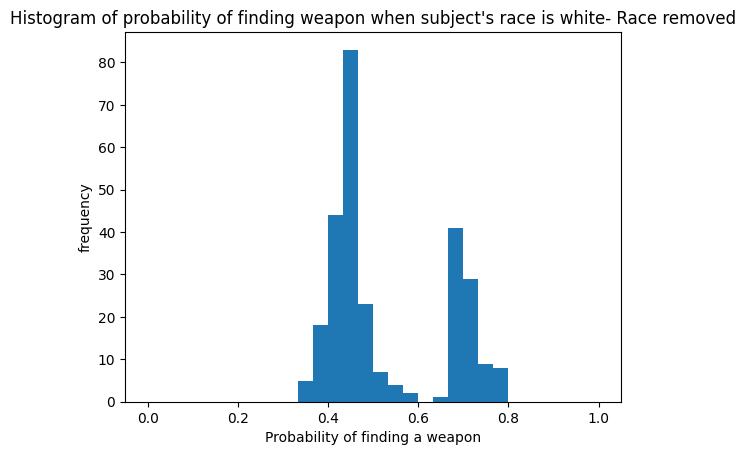

In [ ]:
plt.hist(sub_white['pred_reg_1'],bins=30, range=[0,1],) #plotting histogram
plt.xlabel("Probability of finding a weapon")
plt.ylabel("frequency")
plt.title("Histogram of probability of finding weapon when subject's race is white- Race removed")
plt.show()

**Comment on these histograms in comparison to the previous histograms in which the subjects race was used to predict the outcome.**

Now the histogram for the subject's whose race is white was more symmetric. Yet subjects who race was white had higher probability of a weapon being found. The number of suspects whose race is white is small in comparison to those whose race is black. Yet there is a higher probability of finding a weapon in white subjects.

**Assuming that a probability over `0.5` indicates that the model predicts that a weapon will be found on the suspect, is the model that uses the race of a subject as a feature more or less accurate than the model that does not?**

In [ ]:
feat_te.head()

,perobs,age,inout_I,inout_O,sex_F,sex_M,sex_Z,race_A,race_B,race_I,race_P,race_Q,race_U,race_W,race_Z,pred_reg,pred_reg_1
18871,1,18,0,1,0,1,0,0,0,0,0,1,0,0,0,0.465281,0.454380
493236,5,46,0,1,0,1,0,0,0,0,0,1,0,0,0,0.510282,0.451504
435835,2,16,0,1,0,1,0,0,0,0,1,0,0,0,0,0.470025,0.415082
111074,5,51,0,1,1,0,0,0,1,0,0,0,0,0,0,0.395015,0.421007
75988,1,19,0,1,0,1,0,0,1,0,0,0,0,0,0,0.407928,0.442174


In [ ]:
feat_te['pred_with_race'] = feat_te['pred_reg'].apply(lambda x: 1 if x > 0.5 else 0)
feat_te['pred_without_race'] = feat_te['pred_reg_1'].apply(lambda x: 1 if x > 0.5 else 0)

In [ ]:
feat_te['targ']=targ_te

In [ ]:
feat_te.head()

,perobs,age,inout_I,inout_O,sex_F,sex_M,sex_Z,race_A,race_B,race_I,race_P,race_Q,race_U,race_W,race_Z,pred_reg,pred_reg_1,pred_with_race,pred_without_race,targ
18871,1,18,0,1,0,1,0,0,0,0,0,1,0,0,0,0.465281,0.454380,0,0,0
493236,5,46,0,1,0,1,0,0,0,0,0,1,0,0,0,0.510282,0.451504,1,0,0
435835,2,16,0,1,0,1,0,0,0,0,1,0,0,0,0,0.470025,0.415082,0,0,0
111074,5,51,0,1,1,0,0,0,1,0,0,0,0,0,0,0.395015,0.421007,0,0,0
75988,1,19,0,1,0,1,0,0,1,0,0,0,0,0,0,0.407928,0.442174,0,0,1


In [ ]:
x=feat_te['pred_with_race'].values.reshape(-1, 1)
y=feat_te['pred_without_race'].values.reshape(-1, 1)

In [ ]:
acc_te = accuracy_score(targ_te, x)
print("testing accuracy with race= {0:.3f}".format(acc_te))

testing accuracy with race= 0.599


In [ ]:
acc_te = accuracy_score(targ_te, y)
print("testing accuracy without race= {0:.3f}".format(acc_te))

testing accuracy without race= 0.584


In [ ]:
#Model with race
fp = ((feat_te['targ'] == 0) & (feat_te['pred_with_race'] == 1)).sum()
fn = ((feat_te['targ'] == 1) & (feat_te['pred_with_race'] == 0)).sum()
tp = ((feat_te['targ'] == 1) & (feat_te['pred_with_race'] == 1)).sum()
tn = ((feat_te['targ'] == 0) & (feat_te['pred_with_race'] == 0)).sum()
# print the results

print('False Positive:', fp)
print('False Negative:', fn)
print('True Positive:', tp)
print('True Negative:', tn)

False Positive: 298
False Negative: 645
True Positive: 538
True Negative: 869


In [ ]:
#Model without race
fp = ((feat_te['targ'] == 0) & (feat_te['pred_without_race'] == 1)).sum()
fn = ((feat_te['targ'] == 1) & (feat_te['pred_without_race'] == 0)).sum()
tp = ((feat_te['targ'] == 1) & (feat_te['pred_without_race'] == 1)).sum()
tn = ((feat_te['targ'] == 0) & (feat_te['pred_without_race'] == 0)).sum()
# print the results
print('False Positive:', fp)
print('False Negative:', fn)
print('True Positive:', tp)
print('True Negative:', tn)

False Positive: 191
False Negative: 787
True Positive: 396
True Negative: 976


Testing accuracy with race is slightly higher (0.598) than testing accuracy of the model without race (0.584). True positives and false positives are more in the model with race and true negatives and false negatives are more in the model without race.